# Data Analysis Workshop
## Tutorial II: Adding your own data to the databrowser


In the last tutorial we have learned how to search for datasets, inspect their metadata and access their data. This was only possible because we could make use of data that is indexed in the databrowser. 

What if you want to work with data that is not indexed, for example your own model simulations?

In this tutorial we are going to add our own data to the index. The data we are going to use contains extreme value statistics, but feel free to adjust the data location as you like:

In [36]:
from getpass import getuser
from pathlib import Path
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from freva_client import databrowser, authenticate
import xarray as xr

Let's open the data sets that we'd like to add. It is not strictly neccesary to open the but it makes live easier since some of the metadata can be retrieved from the data. For the rest of the neccesary metadata we need to set some attributes:

In [37]:
datasets = [xr.open_dataset(f,  decode_timedelta=True) for f in Path("/work/ch1187/regiklim-work/k204230/regiklim-ces/output/climdexcalc/20230414_121910").rglob("*.nc")]
global_attributes = {"project": "userdata", "product": "stats", "model": "IFS", "experiment": "ETCCDI", "realm": "atmos", "user": getuser()}

In order to add data to the search server we need to authenticate. Todo so, let's head over to https://www.gems.dkrz.de log in and copy the token content: 

In [12]:
# <copy-paste> the token content from the web site below
token = """ """
_ = (Path.home() / ".freva-access-token.json").write_text(token)

In [38]:
token = authenticate(token_file=Path.home() / ".freva-access-token.json")

In [39]:
databrowser.userdata("add", datasets, metadata=global_attributes, fail_on_error=True)

[2025-07-31T01:05:00] ERROR    freva-client: Error processing batch: list index out of range

No data was added to the databrowser. 3 files were duplicates and not added.

The data has now been added to the central index and can be searched via the `user` flavour

In [17]:
db = databrowser(experiment="ETCCDI", flavour="user", time_frequency="mon")
list(db)

['/work/ch1187/regiklim-work/k204230/regiklim-ces/output/climdexcalc/20230414_121910/reanalysis/reanalysis/ecmwf/ifs/era5/mon/atmos/tnnetccdi/r1i1p1/tnnetccdi_mon_ifs_era5_r1i1p1_2000-2001.nc',
 '/work/ch1187/regiklim-work/k204230/regiklim-ces/output/climdexcalc/20230414_121910/reanalysis/reanalysis/ecmwf/ifs/era5/mon/atmos/tn90petccdi/r1i1p1/tn90petccdi_mon_ifs_era5_r1i1p1_2000-2001.nc',
 '/work/ch1187/regiklim-work/k204230/regiklim-ces/output/climdexcalc/20230414_121910/reanalysis/reanalysis/ecmwf/ifs/era5/mon/atmos/dtretccdi/r1i1p1/dtretccdi_mon_ifs_era5_r1i1p1_2000-2001.nc']

Let's access and plot the data:

In [20]:
data = xr.open_mfdataset(db, combine="by_coords")
data

<xarray.Dataset> Size: 236MB
Dimensions:      (time: 24, lon: 1280, lat: 640, bnds: 2)
Coordinates:
  * time         (time) datetime64[ns] 192B 2000-01-16 2000-02-15 ... 2001-12-16
  * lon          (lon) float64 10kB -179.9 -179.6 -179.3 ... 179.3 179.6 179.9
  * lat          (lat) float64 5kB -89.86 -89.58 -89.3 ... 89.3 89.58 89.86
Dimensions without coordinates: bnds
Data variables:
    time_bnds    (time, bnds) float64 384B dask.array<chunksize=(1, 2), meta=np.ndarray>
    tnnETCCDI    (time, lat, lon) float32 79MB dask.array<chunksize=(1, 640, 1280), meta=np.ndarray>
    tn90pETCCDI  (time, lat, lon) float32 79MB dask.array<chunksize=(1, 640, 1280), meta=np.ndarray>
    dtrETCCDI    (time, lat, lon) float32 79MB dask.array<chunksize=(1, 640, 1280), meta=np.ndarray>
Attributes: (12/16)
    CDI:                      Climate Data Interface version 2.0.5 (https://m...
    Conventions:              CF-1.6
    institution:              European Centre for Medium-Range Weather Forecasts
    history:                  Fri Apr 14 12:58:35 2023: cdo -s setlevel,0 /wo...
    license:                  Contains modified Copernicus Atmosphere Monitor...
    input_tracking_id:        d5b13485-16f3-5f65-8dfd-cf03615bcc01
    ...                       ...
    ETCCDI_software_version:  1.1.11
    contact:                  k204230
    frequency:                mon
    creation_date:            2023-04-14T10:30:23Z
    title:                    ETCCDI indices computed on 0
    CDO:                      Climate Data Operators version 2.0.5 (https://m...

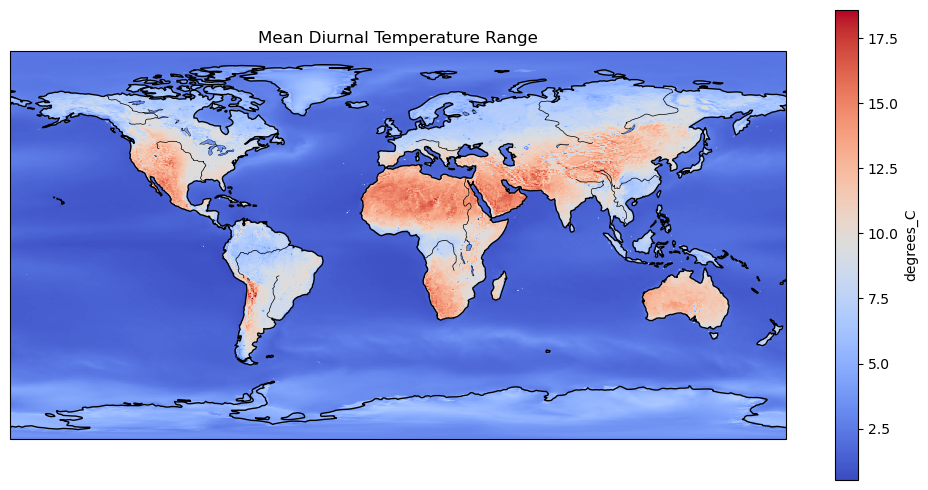

In [35]:
var = "dtrETCCDI"
from matplotlib import pyplot as plt
fig, ax = plt.subplots(
    figsize=(10, 5),
    subplot_kw={"projection": ccrs.PlateCarree()}
)
ax.coastlines()
ax.add_feature(cfeature.RIVERS, linewidth=0.5, edgecolor="black")
ax.add_feature(cfeature.LAKES, linewidth=0.3, edgecolor="black", facecolor="none")
ax.set_global()
p = data[var].mean(dim="time").plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(180),
    cmap="coolwarm",
    shading="auto",
    add_colorbar=True,
    cbar_kwargs={"label": data[var].attrs['units']}
)

# Add title
plt.title(data[var].attrs['long_name'])
plt.tight_layout()
plt.show()